# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random

sys.path.append('../..')
# Experiments
from model import run
from model import plot_utils as pu
from model import processing
from model import init_utils
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import agent_dict, TradeStrategies

# same seed, same parameters = same simulation result
random.seed(42)

initial_state = OmnipoolState(ol
    tokens={
        'HDX': {'liquidity': 1000000, 'LRNA_price': 1},
        'USD': {'liquidity': 1000000, 'LRNA_price': 1},
        'R1': {'liquidity': 1000000, 'LRNA_price': 2},
        'R2': {'liquidity': 3000000, 'LRNA_price': 2/3},
    },
    lrna_fee=0,
    asset_fee=0
)

agents = {
    'Trader': agent_dict(
        r_values = {'R1': 1000000, 'R2': 1000000},
        trade_strategy=TradeStrategies.random_swaps(amount={'R1': 333, 'R2': 1000})
    ), 
    'LP1': agent_dict(
        s_values = {'R1': 500000},
        p_values = {'R1': 2}
    ), 
    'LP2': agent_dict(
        s_values = {'R2': 1500000},
        p_values = {'R2': 2/3}
    )
}

state = {'state': {'amm': initial_state, 'agents': agents, 'external': {}}}
config_dict = init_utils.get_configuration(timesteps = 5000)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 2.54s


In [2]:
rdf, agent_df = processing.postprocessing(events, optional_params=['pool_val', 'deposit_val', 'withdraw_val'])


In [3]:
%matplotlib inline



## Analysis

[0]


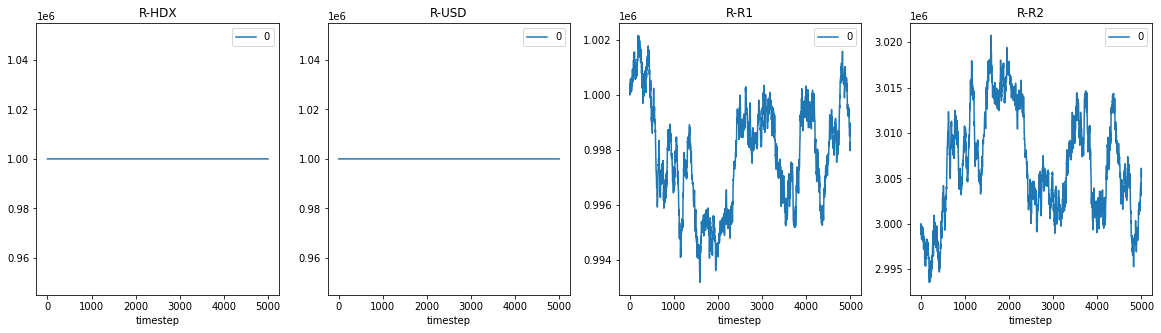

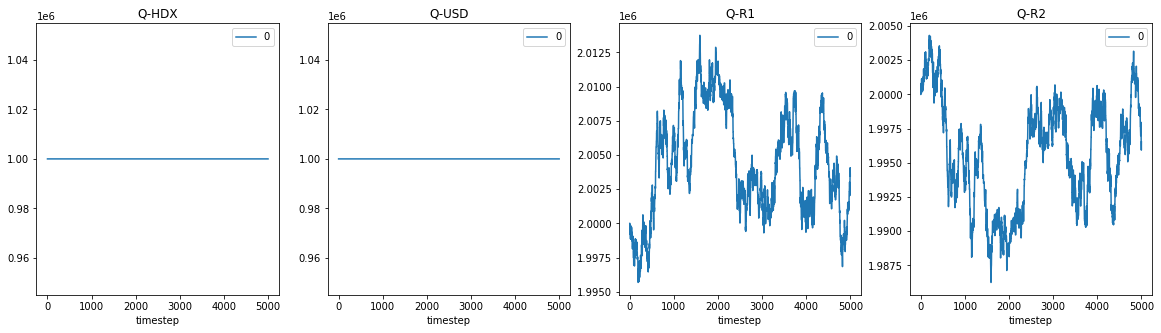

In [4]:
var_list = ['R', 'Q']
pu.plot_vars(rdf, var_list)


[0]


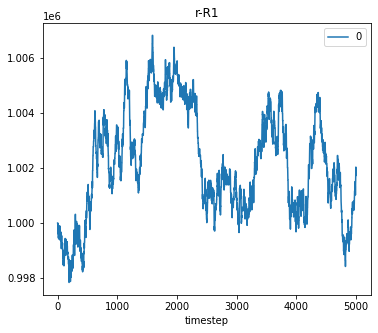

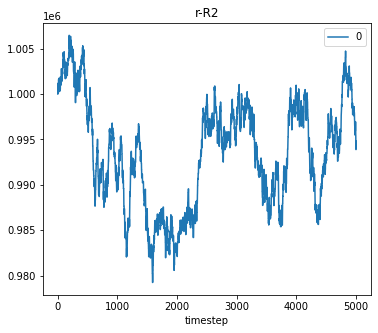

In [5]:
var_list = ['r-R1', 'r-R2']
trader_df = agent_df[agent_df['agent_id'] == 'Trader']
pu.plot_vars(trader_df, var_list)


In [6]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [7]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
merged_df['IL'] = merged_df.apply(lambda x: x['withdraw_val']/x['deposit_val'] - 1, axis=1)

merged_df[['timestep', 'agent_id', 'q','Q-R1', 's-R1','S-R1','r-R1','R-R1','pool_val', 'deposit_val','IL','withdraw_val', 'p-R1']].tail()

,timestep,agent_id,q,Q-R1,s-R1,S-R1,r-R1,R-R1,pool_val,deposit_val,IL,withdraw_val,p-R1
14995,4999,LP1,0,2003469.82,500000,1000000.00,0,998268.09,12000000.0,1003472.83149429,-1.50234902152047e-6,1003471.32392786,2
14996,4999,LP2,0,2003469.82,0,1000000.00,0,998268.09,12000000.0,996533.188336604,-1.5075709550727e-6,996531.685992113,0
14997,5000,Trader,0,2003469.82,0,1000000.00,1001731.90608687,998268.09,12000000.0,2671301.12187965,4.5070402929781e-6,2671313.16154144,0
14998,5000,LP1,0,2003469.82,500000,1000000.00,0,998268.09,12000000.0,1003472.83149429,-1.50234902152047e-6,1003471.32392786,2
14999,5000,LP2,0,2003469.82,0,1000000.00,0,998268.09,12000000.0,996533.188336604,-1.5075709550727e-6,996531.685992113,0


## IL over time



[0]


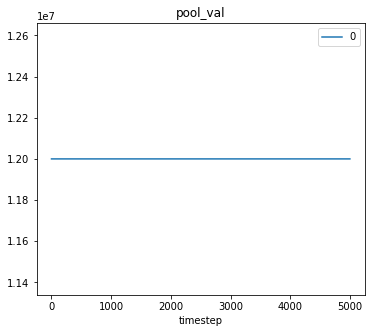

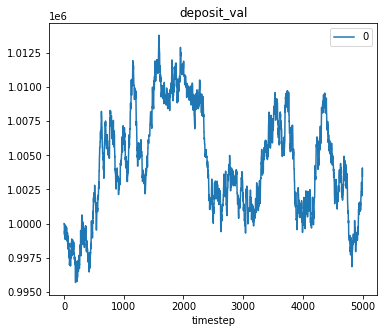

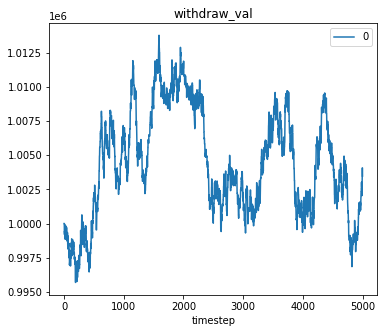

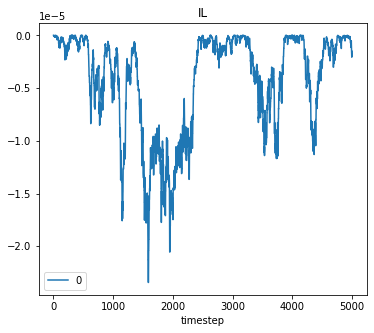

In [8]:
var_list = ['pool_val', 'deposit_val', 'withdraw_val', 'IL']
LP1_merged_df = merged_df[merged_df['agent_id'] == 'LP1']
pu.plot_vars(LP1_merged_df, var_list)

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = \frac{\sqrt{k}k}{k+1} 2Q_i = \left(\frac{2\sqrt{k}k}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

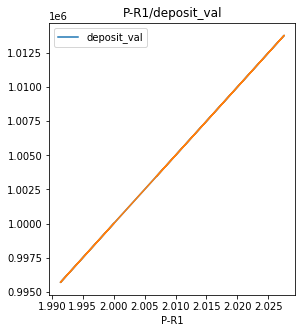

In [9]:
def val_hold_func(P, R):
    return P * R

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-R1/IL')
#LP1_merged_df[['IL','P-R1']].astype(float).plot(ax=ax, y=['IL'], x='P-R1', label=[])
ax = plt.subplot(131, title='P-R1/deposit_val')
LP1_merged_df[['deposit_val','P-R1']].astype(float).plot(ax=ax, y=['deposit_val'], x='P-R1', label=[])

# ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-R1'].tolist()
y = LP1_merged_df.apply(lambda x: val_hold_func(x['P-R1'], agents['LP1']['s']['R1']), axis=1)
ax.plot(x,y, label='Theory')

#ax = plt.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-R1'].tolist()
#y = LP1_merged_df['P-R1'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### $Val_{Pool}$

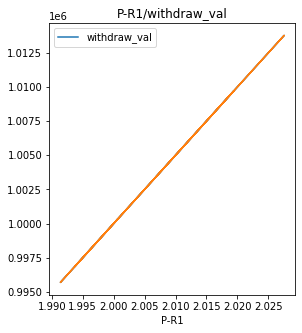

In [10]:
import math
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-R1/IL')
#LP1_merged_df[['IL','P-R1']].astype(float).plot(ax=ax, y=['IL'], x='P-R1', label=[])
ax = plt.subplot(131, title='P-R1/withdraw_val')
LP1_merged_df[['withdraw_val','P-R1']].astype(float).plot(ax=ax, y=['withdraw_val'], x='P-R1', label=[])

# ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-R1'].tolist()
y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-R1'], initial_state.price('R1'), agents['LP1']['s']['R1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-R1'], initial_values['P'][0], x['R-R1']), axis=1)
ax.plot(x, y, label='Theory')

### Impermanent Loss

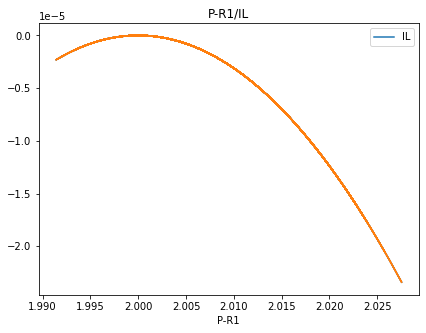

In [11]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-R1/IL')
#LP1_merged_df[['IL','P-R1']].astype(float).plot(ax=ax, y=['IL'], x='P-R1', label=[])
ax = plt.subplot(121, title='P-R1/IL')
LP1_merged_df[['IL','P-R1']].astype(float).plot(ax=ax, y=['IL'], x='P-R1', label=[])

#ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-R1'].tolist()
y = LP1_merged_df.apply(lambda x: IL_func(x['P-R1'], initial_state.price('R1'), agents['LP1']['s']['R1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-R1'], initial_values['P'][0], x['R-R1']), axis=1)
ax.plot(x, y, label='Theory')

#ax = plt.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-R1'].tolist()
#y = LP1_merged_df['P-R1'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

In [12]:
LP1_merged_df[['deposit_val', 'withdraw_val', 'R-R1', 's-R1', 'S-R1', 'P-R1', 'p-R1']].tail()

,deposit_val,withdraw_val,R-R1,s-R1,S-R1,P-R1,p-R1
14986,1003700.92643628,1003699.2143336,998154.66,500000,1000000.00,2.01,2
14989,1004074.6376319,1004072.56230435,997968.89,500000,1000000.00,2.01,2
14992,1004074.6376319,1004072.56230435,997968.89,500000,1000000.00,2.01,2
14995,1003472.83149429,1003471.32392786,998268.09,500000,1000000.00,2.01,2
14998,1003472.83149429,1003471.32392786,998268.09,500000,1000000.00,2.01,2
